### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import gensim
import string
import gzip
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Content Based recommendation system on Google Local Review dataset

### Workflow Diagram

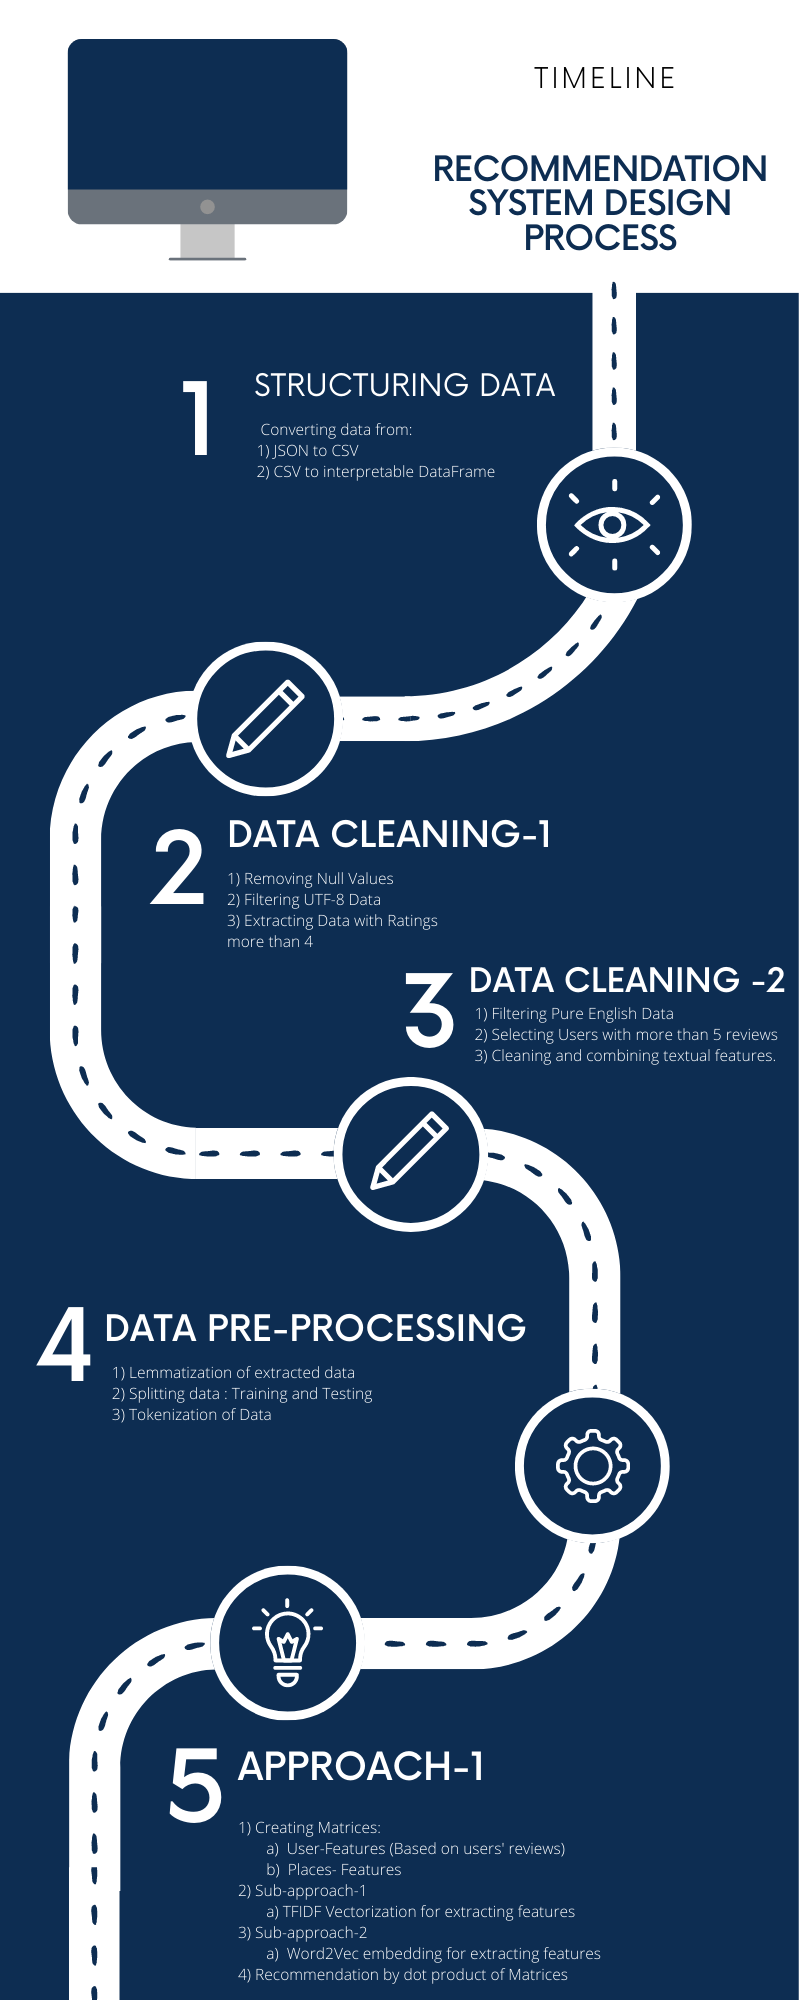

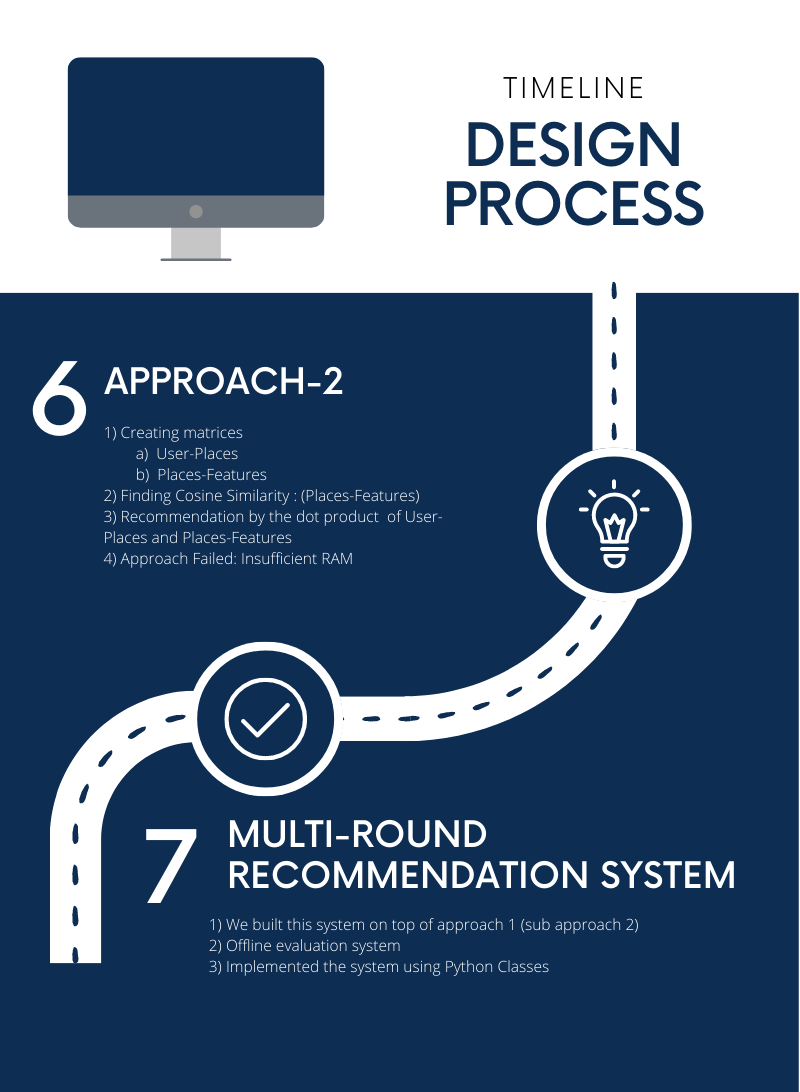

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load JSON DATA

In [ ]:
list1 = []
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    list1.append(eval(l))

In [ ]:
## parse JSON dataset
parse("reviews.clean.json.gz")
df = pd.DataFrame(list1)
df.head()

In [ ]:
## convert JSON data into csv
df.to_csv("Reviews.csv")

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

In [ ]:
## kept the data with more than 3 ratings
df = df[df['rating']>3.0]

In [ ]:
## Drop unusable columns
df.drop("unixReviewTime",axis='columns',inplace=True)

In [ ]:
df.drop('reviewTime',axis='columns',inplace=True)

In [ ]:
## save important DF into CSV file
df.to_csv("Liked.csv")

In [ ]:
df= df.dropna(axis=0)

In [ ]:
## check whether data is in ascii format or not
df =df[df.reviewText.map(lambda x: x.isascii())]

In [ ]:
## group the data by gPlusUserId
df = df.groupby(by='gPlusUserId').count()

In [ ]:
## Fetch the user who have given 4 or more than 4 reviews
df = df[df.groupby(by='gPlusUserId').count()>=4]

In [ ]:
## count the values of gPlusUserId
counts = df['gPlusUserId'].value_counts()

In [ ]:
## user with more than 4 reviews
df = df[~df['gPlusUserId'].isin(counts[counts < 4].index)]

In [ ]:
## group the data by gPlusUserID
df = df.groupby(by='gPlusUserId').count()

In [ ]:
## remove special char with Regex
df=df.replace(r'[^\w\s]',"",regex=True)

#### Fetch the data with Hotel Categories

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data/LikedE.csv")

In [ ]:
df.head()
df.shape

In [ ]:
df_hotel = df[df['categories'].apply(lambda x: 'Hotel' in x)]

In [ ]:
!pip install langdetect
from langdetect import detect
import langdetect

### Filtering Data into English

In [ ]:
# Create a list to store the indices of the rows containing English text
english_rows = []

# Loop through each row in the DataFrame
for i, row in df_hotel.iterrows():
  print(i)
  try:
    if langdetect.detect(row['reviewText']) == 'en':
      english_rows.append(i)
  except:
    continue

# Use the list of indices to extract only the rows containing English text
dx = df_hotel.loc[english_rows]

# Save the cleaned data
dx.to_csv("english_data.csv", index=False)

### Load Cleaned CSV data

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Data/english_data.csv')

In [ ]:
places_count = df1.groupby('gPlusPlaceId')['reviewText'].apply(lambda x: ' '.join(x))
places_count

gPlusPlaceId
100000206364762084593    Great price (on the weekend) and great place. ...
100000287459225104155    Great location and facility Excellent customer...
100000307388846212836    We had a great stay at the oaks. It really is ...
100000462992831294754    What a hotel! Great views, pool and comfort bu...
100001169267249935032    Had a crazy schedule which they worked with.  ...
                                               ...                        
118445551674298868763           great hotel wow i'd love to visit it again
118446065213085838324    Staff are friendly and attentive, rooms are cl...
118446304203779253407    8 off us dined very pleasant atmosphere very g...
118446586268393469168    Great hotel. Amazing stay breakfast was fabulo...
118446723287165573085    I was pleasantly surprised when I was upgraded...
Name: reviewText, Length: 60777, dtype: object

In [ ]:
df1 = df1[df1["categories"].str.contains("hotel", case=False, na=False)]

### NLP preprocessing on Review Text

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
def clean_text(text):
    """
    Clean the text by removing punctuation, stopwords, and converting to lowercase.
    """
    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Convert to lowercase
    text = text.lower()

    # Remove non-English characters
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    cleaned_text = " ".join(words)
    
    return cleaned_text

In [ ]:
df1["category"] = df1["categories"].apply(clean_text)

In [ ]:
df1["reviewText"] = df1["reviewText"].apply(clean_text)

### Dividing users reviews for each user in to train and test datasets

Creating dataframe result containing users having more than or equal to 5 Reviews


In [ ]:
result = (df1.groupby('gPlusUserId\r').filter(lambda x: x.shape[0] >= 5))

In [ ]:
result=result.rename({'gPlusUserId\r': 'gPlusUserId'}, axis=1)

In [ ]:
# Group the result frame by the 'UserID' column
grouped = result.groupby('gPlusUserId')

# Calculate the number of reviews for each user
review_counts = grouped['Reviews'].count()

# Create an empty list to store the test result frames
test_result = []

# Iterate through each group of reviews for a user
for user, group in grouped:
    # Determining the number of reviews to include in the test result frame
    test_size = int(np.ceil(0.2 * len(group)))
    # Split the group of reviews into train and test result frames
    train = group.iloc[:-test_size]
    test = group.iloc[-test_size:]
    # Append the test result frame to the list of test result frames
    test_result.append(test)

# Concatenate all of the test result frames into a single test result frame
test_result = pd.concat(test_result)

# Drop the groups of reviews from the original result frame that were split into the test result frame
train_result = result[~result.index.isin(test_result.index)]

In [ ]:
user_reviews_train = pd.DataFrame(train_result.groupby("gPlusUserId")["Reviews"].apply(lambda x: ' '.join(x)))
user_reviews_test = pd.DataFrame(test_result.groupby("gPlusUserId")["Reviews"].apply(lambda x: ' '.join(x)))

In [ ]:
user_reviews_train.to_csv('train_english_hotel.csv',index=False)
user_reviews_test.to_csv('test_english_hotel.csv',index=False)

## EDA on DATA 

#### Find The Most Frequent Words in Review

In [ ]:
hotel_review = pd.read_csv('/content/drive/MyDrive/Data/english_data.csv')

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(hotel_review['reviewText'].values.astype('U'))
sum_words = words.sum(axis=0)

In [ ]:
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

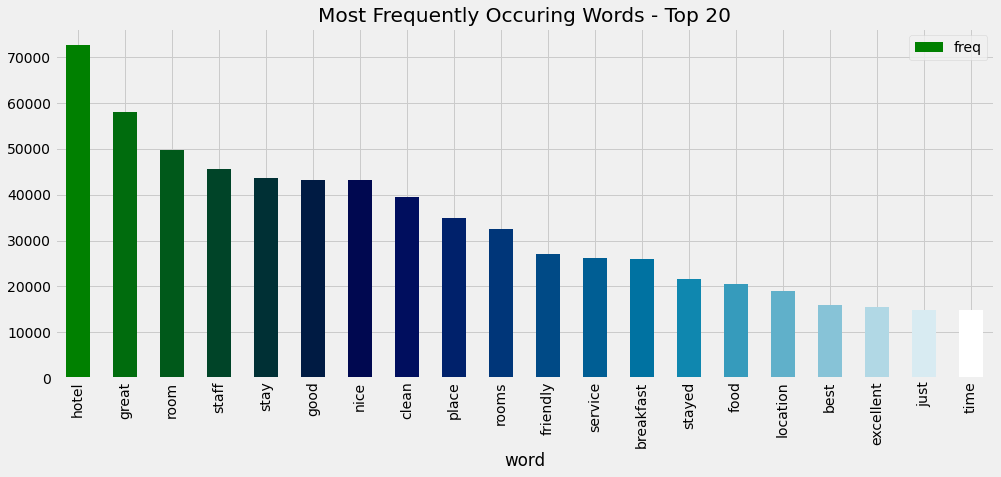

In [ ]:
plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

#### Find The Least Frequent Words in Review

In [ ]:
## Visualizing the Least Frequent Words
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(hotel_review['reviewText'].values.astype('U'))
sum_words = words.sum(axis=0)


In [ ]:
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

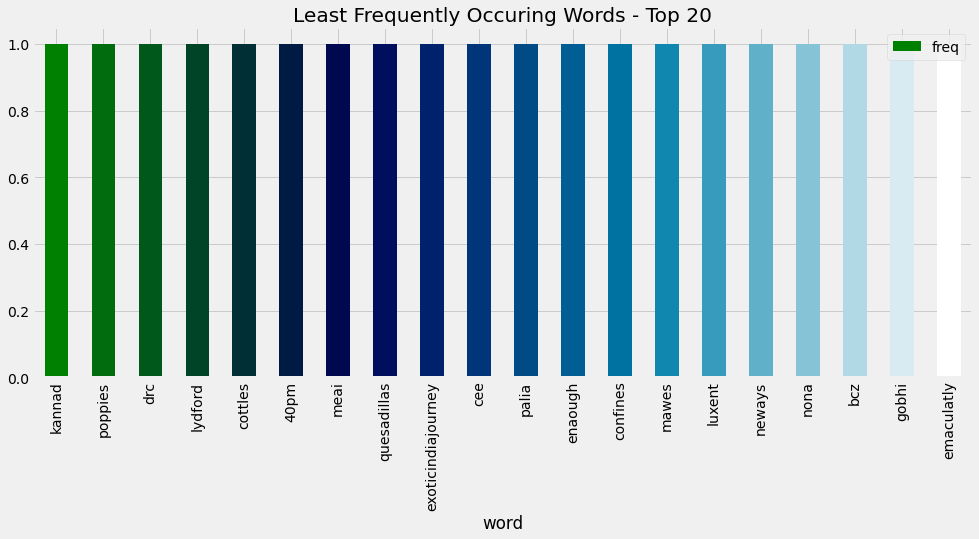

In [ ]:
plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20")
plt.show()

#### Plot Wordscloud 

In [ ]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(hotel_review['reviewText'].values.astype('U'))
sum_words = words.sum(axis=0)

In [ ]:
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

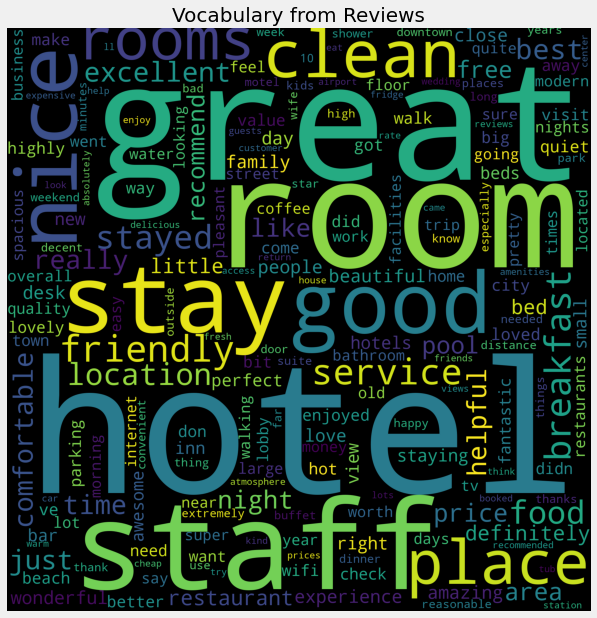

In [ ]:
wordcloud = WordCloud(background_color = 'black', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

### Find Polarity in review Text

In [ ]:
hotel_review['reviewText']= hotel_review['reviewText'].astype(str) #Make sure about the correct data type
pol = lambda x: TextBlob(x).sentiment.polarity
hotel_review['polarity2'] = hotel_review['reviewText'].apply(pol) # depending on the size of your data, this step may take some time.


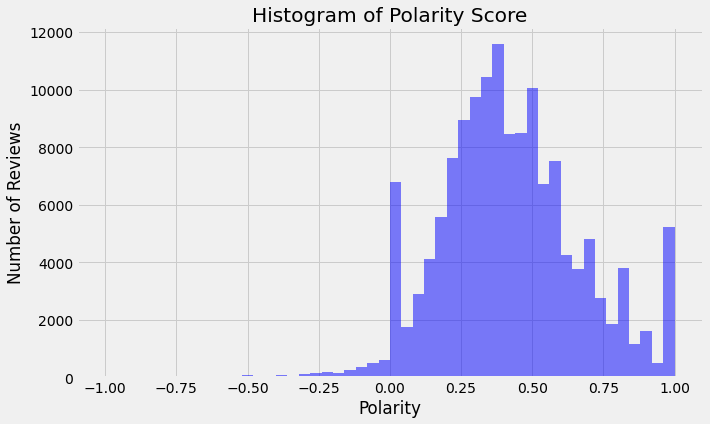

In [ ]:

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(hotel_review.polarity2, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Number of Reviews')
plt.title('Histogram of Polarity Score')
plt.show();

### Find subjectivity in review text

In [ ]:
sub = lambda x: TextBlob(x).sentiment.subjectivity
hotel_review['subjectivity'] = hotel_review['reviewText'].apply(sub)


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Subjectivity Score')

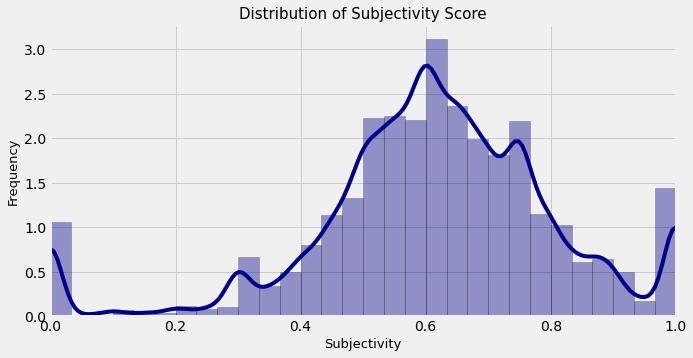

In [ ]:
# Density Plot and Histogram of subjectivity
plt.figure(figsize=(10,5))
sns.distplot(hotel_review['subjectivity'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Subjectivity Score', fontsize=15)

### polarity vs Subjectivity

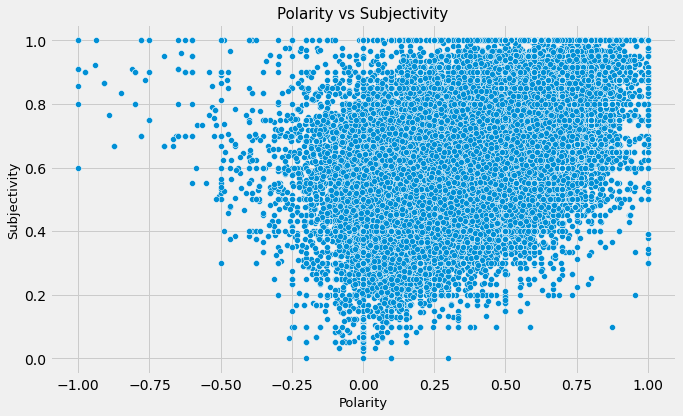

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='polarity2', y='subjectivity', data=hotel_review)
plt.xlabel('Polarity', fontsize=13)
plt.ylabel('Subjectivity', fontsize=13)
plt.title('Polarity vs Subjectivity', fontsize=15)
plt.show();

In [ ]:
hotel_review[['polarity2','subjectivity']].describe()

,polarity2,subjectivity
count,143174.000000,143174.000000
mean,0.419783,0.611289
std,0.249272,0.201253
min,-1.000000,0.000000
25%,0.258810,0.515000
50%,0.400000,0.616667
75%,0.570333,0.735714
max,1.000000,1.000000


### Preprocessing on Only English Reviews

In [ ]:
hotel_review = pd.read_csv('/content/drive/MyDrive/Data/english_data.csv')

In [ ]:
hotel_review

,Unnamed: 0,Unnamed: 0.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,40,40,5,Vary good Tom,Vary good,"['Luxury Hotel', 'Bar']",104375376892323207717,100000078935887875612
1,107,107,5,Alan Tower,This is without a doubt a magnificent hotel. ...,"['Wedding Venue', 'Hotel', 'Meeting Room']",112130363460313652999,100000205979559004579
2,111,111,4,Betsi H,Stayed for 2 nights. I didn't think about make...,['Hotel'],106603636734849878662,100000217241208417605
3,117,117,5,Bill Baumgardner Sr.,"We stayed one night, Oct. 16th-17th. All was g...",['Hotel'],113130708139021351790,100000223173840343321
4,202,202,4,Ahmad Syameel Anuar,Nice place.. good food,['Hotel'],111547561501287745364,100000277477045248814
...,...,...,...,...,...,...,...,...
143169,11453263,11453263,4,Christopher Gross,Parking is a pain and expensive. Hotel is rea...,['Hotel'],109868724615594950212,118445922721592942009
143170,11453289,11453289,5,Christopher Gross,"Wonderful rooms! Close to the waterfront, wal...",['Hotel'],116480408424418486876,118445922721592942009
143171,11453533,11453533,5,Mohit Virmani,"Best motel in bairnsdale; clean, comfortable, ...","['Motel', 'Hotel', 'Lodge']",103486107568272721762,118446341757654846427
143172,11453572,11453572,5,Jessica Neal,We stay at a lot of hotels often disappointed....,['Hotel'],103108667206980646262,118446428523070797633


## Single Shot Recommendation

### Working with Training Sample

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Data/train_english_hotel.csv',lineterminator='\n')
test_data = pd.read_csv('/content/drive/MyDrive/Data/test_english_hotel.csv',lineterminator='\n')

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,['Hotel'],103001068156411967811,100013135713453424885
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,"['Hotel', 'Meeting Room']",103440466000173604514,100013135713453424885
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...","['Hotel', 'Spa', 'Business Center']",103778941603376935348,100013135713453424885
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,"['Hotel', 'Conference Center', 'Meeting Room']",108702848521856826215,100013135713453424885
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,['Hotel'],109236429469860442267,100013135713453424885


### Cleaning the Categories Column

In [ ]:
# Create a translation table for punctuation removal
translator = str.maketrans(' ', ' ', string.punctuation)

# Apply the translation table to the 'Review' column of the data frame
train_data['categories'] = train_data['categories'].str.translate(translator)

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885


### Combining the reviewText and Categories

In [ ]:
train_data['Reviews'] = train_data['reviewText'].astype(str) + ' ' + train_data['categories'].astype(str)

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId,Reviews
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...


### Dropping columns

In [ ]:
train_data = train_data.drop(columns=['rating','reviewText','categories'])

### Getting User Review

In [ ]:
user_reviews = train_data.groupby('gPlusUserId')['Reviews'].apply(lambda x: ' '.join(x))

In [ ]:
user_reviews=user_reviews.reset_index()

In [ ]:
user_reviews

,gPlusUserId,Reviews
0,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,100014808696256719518,If you're looking for a cheap hotel in Baltimo...
2,100051405258786750070,It's a pleasant experience whenever I stay the...
3,100058586200061321240,Wonderful room with very nicely renovated bath...
4,100102481568300652845,A very good business to deal with. They do a g...
...,...,...
1171,118406741913163945471,great hotel and facilities but service was a b...
1172,118418929092089094944,I love this hotel and stay here every time I a...
1173,118440106837924926574,A nice business hotel. The rooms are not big b...
1174,118444881692249356277,This place is the best . For 60 dollars a nigh...


### Getting Places Reviews

In [ ]:
train_data

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,reviewerName,gPlusPlaceId,gPlusUserId,Reviews
0,114,8684,8684,Justin Newnum,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,115,8686,8686,Justin Newnum,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,116,8688,8688,Justin Newnum,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,117,8698,8698,Justin Newnum,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,118,8701,8701,Justin Newnum,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...
...,...,...,...,...,...,...,...
6922,142783,11452468,11452468,mike scott,106745805651323093746,118444881692249356277,Its way better than super 8 and its only 44 a ...
6923,142786,11452932,11452932,Jim Gleason,101017098109846845898,118445626060024034996,Nice place to stay. kinda loud when others wal...
6924,142787,11452938,11452938,Jim Gleason,105241978967270794992,118445626060024034996,Great spot. We will be back. Travel all summer...
6925,142788,11452942,11452942,Jim Gleason,110023273875985696500,118445626060024034996,Front desk lady is nice. Good thing we all che...


In [ ]:
place_reviews = train_data.groupby('gPlusPlaceId')['Reviews'].apply(lambda x: ' '.join(x))
place_reviews = place_reviews.reset_index()
place_reviews

,gPlusPlaceId,Reviews
0,100001662201725936509,"Clean and comfortable, right off of 240 so it ..."
1,100003114499868759188,Excellent brunch with loads of Champagne. A ve...
2,100005357045312990824,We asked for late check-out - and instead they...
3,100005648022375652874,I stayed here for a month on a business trip a...
4,100005902487679056162,"Nice, clean rooms and beds. Very friendly staf..."
...,...,...
5767,118024681257220759034,"The hotel is very modern and clean, staff is v..."
5768,118036950485906465479,Really nice hotel I've never went wrong being ...
5769,118058283660288504246,Owner is very nice and helped us a lot! The pl...
5770,118078983014856071607,was kinda fun to be at your place for some sta...


### Review Tokenization 

In [ ]:
# Tokenize the data
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
reviews = user_reviews['Reviews']
tokenized_reviews = [word_tokenize(review) for review in reviews]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
len(tokenized_reviews)

1176

### Word Embeddings

In [ ]:
# Train the Word2Vec model to create word embedding model
model = gensim.models.Word2Vec(tokenized_reviews, size=200, window=5, min_count=1, workers=8)
# Access the word vectors
word_vectors = model.wv

### Representing Text Review into Vectors

In [ ]:
place_review_array = []
for review in place_reviews['Reviews']:
  word_vector = np.zeros((1, 200))
  for word in word_tokenize(review):
    word_vector += word_vectors[word]
  place_review_array.append(word_vector) 

In [ ]:
place_review_array = np.array(place_review_array)
place_review_array = place_review_array.reshape(-1,200)
place_review_array.shape

(5772, 200)

### Representing Users into vectors

In [ ]:
word_vector = np.zeros((1, 200))
for word in word_tokenize(user_reviews['Reviews'][0]):
    word_vector += word_vectors[word]
    
word_vector

array([[  -5.59832038,  -45.54756442,   17.35955576,  -15.38480856,
         117.21124879,   37.04682464, -103.90577498,   40.13167585,
         153.27424308,  -21.42487338,  -35.93535963, -213.065025  ,
         -58.0601138 ,  -27.62621146, -106.18210379,  -32.06732141,
           6.41173441,   -2.94520547,   -7.98900117,  -11.19340591,
        -112.08378938,  -52.09033584,   97.31822869,   -9.71054666,
          76.17725136,  -20.48829525,   33.98428939,   23.21811047,
         144.65161984,   26.43800167,    6.83909857,  124.28150576,
          44.70494116,  -13.26713235,   75.03176996,    6.61207249,
          -7.30814594,    7.64131638,  -34.94889964,   13.59434817,
          68.36656385,  -47.17876475,   24.16405574,  -63.32154602,
          24.19622622,   42.62419065,   61.49459211,  -78.28054294,
         -18.75415691,   20.39112309,    9.35287477,  -38.25575114,
          38.94735331,   58.19821249,   63.22933971,   -8.07727554,
         -73.00927852,  -33.64451121,   -7.39561

In [ ]:
word_vector.shape

(1, 200)

### Cosine Similarity

In [ ]:
similarities = cosine_similarity(word_vector,place_review_array).flatten()

In [ ]:
place_reviews['Similarity'] = similarities
place_reviews = place_reviews.sort_values("Similarity", ascending=False)
place_reviews.head(10) 

,gPlusPlaceId,Reviews,Similarity
1021,102384235452222736506,A great traditional pub with a really nice bee...,0.994050
5543,115062869998124522825,I was very impressed with my stay at the Ritz-...,0.993426
159,100367551410709355484,It's now called the 85 Sky Tower Hotel. Talle...,0.993063
3754,109249696200314888222,A bit outdated but still very nice. Food in th...,0.992796
4732,111986851198239883217,"Super Convenient Location, Nice rooms, Good se...",0.992789
5372,114235756496502972344,Amazing and stylish hotel. My room was small b...,0.992772
2551,106142265993355599400,"This is a review of Chervil Restaurant, at Hot...",0.992769
219,100523947897370697222,"..and I'm very picky! The room was spotless, T...",0.992710
83,100204564735871304503,I am staying at this hotel this week and it is...,0.992623
2276,105428658018246222325,Great place to stay in the heart of Temple Bar...,0.992578


In [ ]:
place_reviews.iloc[:,1]

1021    A great traditional pub with a really nice bee...
5543    I was very impressed with my stay at the Ritz-...
159     It's now called the 85 Sky Tower Hotel.  Talle...
3754    A bit outdated but still very nice. Food in th...
4732    Super Convenient Location, Nice rooms, Good se...
                              ...                        
1475                     Ge4093 remodel stayed here Hotel
5445    Near to skywalk I remember I used this way to ...
1549                                 Cbelive on you Hotel
2528                     I m currently staying here Hotel
1491                          Want to go back again Hotel
Name: Reviews, Length: 5772, dtype: object

In [ ]:
places=pd.read_csv('/content/drive/MyDrive/Data/places_eng (1).csv')

In [ ]:
places

,Unnamed: 0,name,gPlusPlaceId
0,2,Portofino,109810290098030327104
1,3,T C's Referee Sports Bar,100327153115986850675
2,4,Carrefour - Palembang Square,103368487323937936043
3,5,Pizzeria Montana,103903929544828620241
4,6,Single Tree Inn,103848836623683146185
...,...,...,...
2673565,3114347,Spirit Cafe & Restaurant,101376696259214885024
2673566,3114349,Sabbia D'Oro Iniziative Turistiche S.R.L.,107452257463204448534
2673567,3114350,Assembly of God Church High School,100753085206968749306
2673568,3114351,Buccaneer,110683973849480222025


In [ ]:
result=places.merge(place_reviews,on="gPlusPlaceId",how="right")

In [ ]:
result

,Unnamed: 0,name,gPlusPlaceId,Reviews,Similarity
0,62444.0,The Lamb Inn,102384235452222736506,A great traditional pub with a really nice bee...,0.994050
1,1807056.0,"The Ritz-Carlton Key Biscayne, Miami",115062869998124522825,I was very impressed with my stay at the Ritz-...,0.993426
2,370467.0,The Splendor Kaohsiung,100367551410709355484,It's now called the 85 Sky Tower Hotel. Talle...,0.993063
3,737103.0,The Historic Plains Hotel,109249696200314888222,A bit outdated but still very nice. Food in th...,0.992796
4,1625018.0,Super 8 Salt Lake City Airport,111986851198239883217,"Super Convenient Location, Nice rooms, Good se...",0.992789
...,...,...,...,...,...
5767,1806338.0,TownePlace Suites Erie,103507487805761202770,Ge4093 remodel stayed here Hotel,0.705464
5768,2131556.0,Renaissance Bangkok Ratchaprasong Hotel,114532647980879428714,Near to skywalk I remember I used this way to ...,0.698685
5769,1960798.0,Hotel Michelangelo,103680737672714428868,Cbelive on you Hotel,0.697998
5770,571030.0,Stately Suites Golf Course Road,106091057797382720955,I m currently staying here Hotel,0.697758


## Multi-round Recommendation

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Data/train_english_hotel (1).csv', lineterminator="\n")
test_data = pd.read_csv('/content/drive/MyDrive/Data/test_english_hotel.csv', lineterminator="\n")

place_data = pd.read_csv('/content/drive/MyDrive/Data/User_convert.csv', lineterminator="\n")

In [ ]:
places = pd.read_csv('/content/drive/MyDrive/Data/places_eng (1).csv')

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,['Hotel'],103001068156411967811,100013135713453424885
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,"['Hotel', 'Meeting Room']",103440466000173604514,100013135713453424885
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...","['Hotel', 'Spa', 'Business Center']",103778941603376935348,100013135713453424885
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,"['Hotel', 'Conference Center', 'Meeting Room']",108702848521856826215,100013135713453424885
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,['Hotel'],109236429469860442267,100013135713453424885


In [ ]:
test_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,121,8720,8720,4.0,Justin Newnum,The only downside to this HGI is the breakfast...,['Hotel'],114673041950506135029,100013135713453424885
1,122,8722,8722,4.0,Justin Newnum,Very nice Hampton Inn. The staff is friendly a...,['Hotel'],115118687338834410632,100013135713453424885
2,146,10169,10169,4.0,Amber King,I've only experienced their rooftop bar thus f...,['Hotel'],111051694922506031389,100014808696256719518
3,147,10316,10316,4.0,Amber King,Times Square is so annoying that you forget th...,['Hotel'],116428268837918686175,100014808696256719518
4,148,10336,10336,4.0,Amber King,"I haven't actually stayed here, but I stopped ...","['Hotel', 'Wedding Venue', 'Luxury Hotel']",117190225183204714636,100014808696256719518


In [ ]:
place_name = dict(zip( places['gPlusPlaceId'],places['name']))

In [ ]:
place_name

### Cleaning the Categories Column

In [ ]:
import string

# Create a translation table for punctuation removal
translator = str.maketrans(' ', ' ', string.punctuation)

# Apply the translation table to the 'Review' column of the data frame
train_data['categories'] = train_data['categories'].str.translate(translator)
place_data['categories'] = place_data['categories'].str.translate(translator)


In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885


In [ ]:
place_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885


### Combining the reviewText and Categories

In [ ]:
train_data['Reviews'] = train_data['reviewText'].astype(str) + ' ' + train_data['categories'].astype(str)

In [ ]:
train_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId,Reviews
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...


In [ ]:
place_data['Reviews'] = place_data['reviewText'].astype(str) + ' ' + place_data['categories'].astype(str)
place_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,rating,reviewerName,reviewText,categories,gPlusPlaceId,gPlusUserId,Reviews
0,114,8684,8684,4.0,Justin Newnum,Clean and spacious rooms. The breakfast is rea...,Hotel,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,115,8686,8686,5.0,Justin Newnum,One of the best Hampton Inns I have stayed at....,Hotel Meeting Room,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,116,8688,8688,5.0,Justin Newnum,"Friendly and helpful staff, clean facilities, ...",Hotel Spa Business Center,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,117,8698,8698,4.0,Justin Newnum,The one real down side is there is no computer...,Hotel Conference Center Meeting Room,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,118,8701,8701,5.0,Justin Newnum,Clean somewhat new Hampton Inn. Staff is very ...,Hotel,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...


### Dropping Irrelevant Columns

In [ ]:
train_data = train_data.drop(columns=['rating','reviewText','categories','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
place_data = place_data.drop(columns=['rating','reviewText','categories','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])

In [ ]:
train_data.head()

,reviewerName,gPlusPlaceId,gPlusUserId,Reviews
0,Justin Newnum,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,Justin Newnum,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,Justin Newnum,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,Justin Newnum,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,Justin Newnum,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...


In [ ]:
place_data.head()

,reviewerName,gPlusPlaceId,gPlusUserId,Reviews
0,Justin Newnum,103001068156411967811,100013135713453424885,Clean and spacious rooms. The breakfast is rea...
1,Justin Newnum,103440466000173604514,100013135713453424885,One of the best Hampton Inns I have stayed at....
2,Justin Newnum,103778941603376935348,100013135713453424885,"Friendly and helpful staff, clean facilities, ..."
3,Justin Newnum,108702848521856826215,100013135713453424885,The one real down side is there is no computer...
4,Justin Newnum,109236429469860442267,100013135713453424885,Clean somewhat new Hampton Inn. Staff is very ...


### Lemmatizing Reviews

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on each text in the column
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word.lower() not in stop_words])

# Apply the lemmatization function to the 'text' column
train_data['Reviews'] = train_data['Reviews'].apply(lemmatize_text)
place_data['Reviews'] = place_data['Reviews'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Getting User Reviews

In [ ]:
user_reviews = train_data.groupby('gPlusUserId')['Reviews'].apply(lambda x: ' '.join(x))

In [ ]:
user_reviews = user_reviews.reset_index()

In [ ]:
user_reviews

,gPlusUserId,Reviews
0,100013135713453424885,Clean spacious room . breakfast really well do...
1,100014808696256719518,"'re looking cheap hotel Baltimore , pretty goo..."
2,100051405258786750070,"'s pleasant experience whenever stay . Food , ..."
3,100058586200061321240,Wonderful room nicely renovated bathroom . Own...
4,100102481568300652845,good business deal . great job helping organiz...
...,...,...
1171,118406741913163945471,great hotel facility service bit odd - charged...
1172,118418929092089094944,love hotel stay every time Orlando business . ...
1173,118440106837924926574,nice business hotel . room big fully functiona...
1174,118444881692249356277,place best . 60 dollar night find better place...


### Getting Place Reviews

In [ ]:
place_reviews = place_data.groupby('gPlusPlaceId')['Reviews'].apply(lambda x: ' '.join(x))
place_reviews = place_reviews.reset_index()
place_reviews

,gPlusPlaceId,Reviews
0,100001662201725936509,"Clean comfortable , right 240 convenient well ..."
1,100003114499868759188,Excellent brunch load Champagne . good variety...
2,100005357045312990824,asked late check-out - instead gave u pas gym ...
3,100005648022375652874,stayed month business trip really enjoyed . ro...
4,100005902487679056162,"Nice , clean room bed . friendly staff . Break..."
...,...,...
7510,118441267330016271927,Excellent centrally located hotel . Nice room ...
7511,118443494962996400304,"nice room , great facility ( pool w/waterslide..."
7512,118444314842259010591,Nice clean modern safe hotel Hotel Extended St...
7513,118445551674298868763,great hotel Lodging Luxury Hotel wow 'd love v...


### Tokenization

In [ ]:
# Tokenize the data
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

reviews = place_reviews['Reviews']
tokenized_reviews = [word_tokenize(review) for review in reviews]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
len(tokenized_reviews)

7515

### Word Embeddings Creation

In [ ]:
# Word Embeddings Creation

import gensim

# Train the Word2Vec model
model = gensim.models.Word2Vec(tokenized_reviews, size=300, window=5, min_count=1, workers=8)
# Access the word vectors
word_vectors = model.wv

### Representing a place review into vector

In [ ]:
import numpy as np

place_review_array = []
for review in place_reviews['Reviews']:
  word_vector = np.zeros((1, 300))
  for word in word_tokenize(review):
    word_vector += word_vectors[word]
  place_review_array.append(word_vector/len(review)) 

In [ ]:
place_review_array = np.array(place_review_array)
place_review_array = place_review_array.reshape(-1,300)
place_review_array.shape

(7515, 300)

### Representing a user review into vector

In [ ]:
user_review_array = np.zeros((1, 300))
for word in word_tokenize(user_reviews['Reviews'][1171]):
    user_review_array += word_vectors[word]
    
user_review_array = user_review_array/len(user_reviews['Reviews'][1171])

In [ ]:
user_review_array = []
for review in user_reviews['Reviews']:
  user_word_vector = np.zeros((1, 300))
  for word in word_tokenize(review):
    user_word_vector += word_vectors[word]
  user_review_array.append(user_word_vector/len(review)) 

In [ ]:
user_review_array = np.array(user_review_array)
user_review_array = user_review_array.reshape(-1,300)
user_review_array.shape

(1176, 300)

In [ ]:
user_review_array

array([[-0.04238077,  0.02842738,  0.09555526, ..., -0.02183262,
         0.10564472, -0.02402558],
       [-0.01470389,  0.04341278,  0.09573792, ..., -0.00859022,
         0.10145946, -0.01253801],
       [-0.03213226,  0.03846744,  0.11396749, ..., -0.01887871,
         0.12020058, -0.02402201],
       ...,
       [-0.01887896,  0.03917703,  0.08146208, ..., -0.01097763,
         0.09134769, -0.01127929],
       [-0.03317442,  0.03669314,  0.09324215, ..., -0.01653617,
         0.10649307, -0.01715439],
       [-0.02259278,  0.0471566 ,  0.12082248, ..., -0.01328538,
         0.11603059, -0.02068857]])

### MultiRound Recommendation Class

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def user_index(df_user):  # user groupby df
    user_dct = {row['gPlusUserId']: i for i,row in df_user.iterrows()}
    return user_dct


def place_index(df_place):  # place groupby df
    place_dct = {row['gPlusPlaceId']: i for i,row in df_place.iterrows()}
    return place_dct

place_name = dict(zip( places['gPlusPlaceId'],places['name']))
user_key = user_index(user_reviews)
place_key = place_index(place_reviews)

In [ ]:
class MultiRoundRecommendation():
    
    #Initialization
    def __init__(self,user_mat,item_mat,user_key,place_names,place_key,place_reviews):
        
        self.user_feature = user_mat
        self.feature_item = item_mat
        self.userkeys = user_key # userid and index in 
        self.place_reviews = place_reviews 
        self.placenames = place_names  # name and place id 
        self.placekey = place_key   # placeid and index 

    # Single Shot recommendation 
    def get_recommendation(self,user_id):

        idx= self.userkeys[user_id]
        user_review_array= self.user_feature[idx]
        user_review_array = user_review_array.reshape(1,-1)
        similarities = cosine_similarity(user_review_array,self.feature_item).flatten()
        self.place_reviews['Similarity'] = similarities
        self.place_reviews= self.place_reviews.sort_values("Similarity",ascending = False)
        places_id = self.place_reviews.iloc[0:10,0] 
        # print(type(places_id))
        names = places_id.map(self.placenames)
        return names, self.place_reviews.iloc[0:10,-1],places_id

    def multiround(self,user_id,final_place):
        
        # Final Place : gplusplaceid 
        target_index = self.placekey[final_place]
        target_features = self.feature_item[target_index]
        target_features = target_features.reshape(1,-1)
        names,series,places_id = self.get_recommendation(user_id)
        

        
        
        round = 0
        while round < 8:
            round=round+1
            temp_index = places_id.map(place_key)
            temp_feature = []
            # chatgpt  vectorization
            temp_df = self.place_reviews.iloc[temp_index]
            for i in temp_index:
                temp_feature.append(self.feature_item[i])
            
            temp_feature = np.array(temp_feature)
            temp_feature = temp_feature.reshape(-1,300)
            # print(temp_feature)
            # print(temp_feature.shape)
            temp_similarities = cosine_similarity(temp_feature,target_features).flatten() 
            temp_df['Similarity'] = temp_similarities
            temp_df= temp_df.sort_values("Similarity",ascending = False)
            temp_series = temp_df.iloc[0:10,-1]
            places_id = temp_df.iloc[0:10,0] 
            
            names = places_id.map(self.placenames)
            #Breakpoint
            if 1.0 in temp_series:
                print(f"The desired place is found in {round} round.")
                # print(names)
                break
            print(f"Recommendation for round {round}")
            print(names)
            print('\n')

            # predictions for round n
            next_feature_index = self.placekey[temp_df.iloc[0,0]]
            
            next_feature = self.feature_item[next_feature_index]
            next_feature = np.array(next_feature)
            next_feature = next_feature.reshape(-1,300)
            similarities = cosine_similarity(next_feature,self.feature_item).flatten()
            self.place_reviews['Similarity'] = similarities
            self.place_reviews= self.place_reviews.sort_values("Similarity",ascending = False)
            places_id = self.place_reviews.iloc[1:11,0]

            

In [ ]:
import warnings
warnings.filterwarnings("ignore")

MRR = MultiRoundRecommendation(user_review_array,place_review_array,user_key,place_name,place_key,place_reviews)
MRR.multiround('100013135713453424885','111373284500724046070')

Recommendation for round 1
2807                              Jakarta Hotels
7340                           Omena Hotellit Oy
6948    Brook Whipper In Hotel - Hotel in Oakham
5875                       Hilton Akron/Fairlawn
4781       The Tuscany - A St Giles Luxury Hotel
1672           Golden Chain Nicholas Royal Motel
7492                                         NaN
4282                                  Bull Hotel
2823                        Comfort Inn & Suites
4507                     Loews Miami Beach Hotel
Name: gPlusPlaceId, dtype: object


Recommendation for round 2
4954                                         Capri Inn
6844                           Americas Best Value Inn
2790                   South Point Hotel, Casino & Spa
5876                                         Stair Inn
4495        The Inn At The Spanish Steps by Morgan Srl
2209                                    Grumpy's Hotel
5548    Best Western Plus International Speedway Hotel
1256                               